<div class="alert">
    <h1 align="center">Image Classification (Cats vs Dogs)</h1>
</div>

<a href="https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition">dataset</a>

<img src='imgs/catsanddogs.png' width='90%'/>

## Objectives

- Image classification
- Four key components of any ML system (in PyTorch):
 - Data (Images)
 - Model (CNN)
 - Loss (Cross Entropy)
 - Optimization (SGD, Adam, ..)
- Convolutional Neural Networks (CNNs)
- Overfit
- Data augmentation
- Transfer learning

## Libraries

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
        
import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [4]:
use_gpu

True

## Data

- train: learning the **parameters** of the model.
- valid: learning **hyper-parameters**.
- test
- development

In [6]:
DATA_DIR = 'G:/cat_vs_dog/data/'
sz = 224
batch_size = 32

In [8]:
os.listdir(DATA_DIR)

['dev', 'test', 'train']

**organize data**

In [12]:
import os
import shutil

def create_directories(base_dir):
    """
    Create the necessary directories for training and validation.

    Args:
    base_dir (str): The base directory where the 'train' and 'valid' directories will be created.

    This function creates the following directory structure:
    base_dir/
        train/
            cat/
            dog/
        valid/
            cat/
            dog/
    
    Modules used:
    - os: Provides a way of using operating system dependent functionality like reading or writing to the file system.
        - os.path.join: Joins one or more path components intelligently.
        - os.makedirs: Recursively creates directories. If the directory already exists, it does nothing.
    """
    directories = [
        os.path.join(base_dir, "train", "cat"),
        os.path.join(base_dir, "train", "dog"),
        os.path.join(base_dir, "valid", "cat"),
        os.path.join(base_dir, "valid", "dog")
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)

def list_files(source_dir):
    """
    List all cat and dog files in the source directory.
    Args:
    source_dir (str): The directory where the original images are stored.
    Returns:
    tuple: A tuple containing two lists:
        - cat_files: A list of filenames that start with 'cat.'.
        - dog_files: A list of filenames that start with 'dog.'.

    Modules used:
    - os: Provides a way of using operating system dependent functionality.
        - os.listdir: Returns a list of the names of the entries in the directory given by path.
    """
    all_files = os.listdir(source_dir)
    cat_files = [f for f in all_files if f.startswith('cat.')]
    dog_files = [f for f in all_files if f.startswith('dog.')]
    return cat_files, dog_files

def move_files(files, target_dir):
    """
    Move files to the target directory.

    Args:
    files (list): A list of file paths to be moved.
    target_dir (str): The directory where the files will be moved.

    Modules used:
    - shutil: Offers a number of high-level operations on files and collections of files.
        - shutil.copy: Copies the file to the specified directory.
    """
    for file in files:
        shutil.copy(file, target_dir)

def organize_files(source_dir, target_dir, train_count):
    """
    Organize cat and dog files into training and validation sets.

    Args:
    source_dir (str): The directory where the original images are stored.
    target_dir (str): The base directory where the 'train' and 'valid' directories will be created.
    train_count (int): The number of files to be used for training. Validation count will be 25% of train_count.

    This function organizes the files by:
    1. Creating necessary directories.
    2. Listing all cat and dog files in the source directory.
    3. Moving the specified number of cat and dog files to the training directory.
    4. Moving 25% of the training count of cat and dog files to the validation directory.

    Modules used:
    - os: Provides a way of using operating system dependent functionality.
        - os.path.join: Joins one or more path components intelligently.
    """
    create_directories(target_dir)
    
    cat_files, dog_files = list_files(source_dir)

    # Calculate validation count as 25% of train count
    valid_count = train_count // 4
    
    # Move cat files
    move_files([os.path.join(source_dir, f) for f in cat_files[:train_count]], 
               os.path.join(target_dir, "train", "cat"))
    move_files([os.path.join(source_dir, f) for f in cat_files[train_count:train_count + valid_count]], 
               os.path.join(target_dir, "valid", "cat"))

    # Move dog files
    move_files([os.path.join(source_dir, f) for f in dog_files[:train_count]], 
               os.path.join(target_dir, "train", "dog"))
    move_files([os.path.join(source_dir, f) for f in dog_files[train_count:train_count + valid_count]], 
               os.path.join(target_dir, "valid", "dog"))

def main():
    """
    The main function to organize cat and dog files into training and validation sets.

    This function specifies the source and target directories and calls the organize_files function.

    Variables:
    - source_dir (str): The directory where the original images are stored.
    - target_dir (str): The base directory where the 'train' and 'valid' directories will be created.
    - train_count (int): The number of files to be used for training. Validation count will be 25% of train_count.
    """
    source_dir = r"G:\cat_vs_dog\data\train"
    target_dir = r"G:\cat_vs_dog\data\dev"
    
    organize_files(source_dir, target_dir, 1000)
    print("Files have been organized successfully.")

if __name__ == "__main__":
    main()

Files have been organized successfully.


In [13]:
DATA_DIR = 'G:/cat_vs_dog/data/dev/'
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [14]:
os.listdir(trn_dir)

['cat', 'dog']

In [15]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg')
trn_fnames[:5]

['G:/cat_vs_dog/data/dev/train\\cat\\cat.0.jpg',
 'G:/cat_vs_dog/data/dev/train\\cat\\cat.1.jpg',
 'G:/cat_vs_dog/data/dev/train\\cat\\cat.10.jpg',
 'G:/cat_vs_dog/data/dev/train\\cat\\cat.100.jpg',
 'G:/cat_vs_dog/data/dev/train\\cat\\cat.1000.jpg']

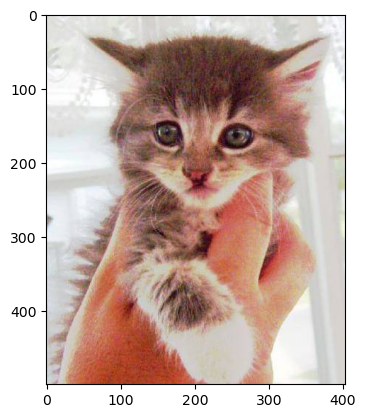

In [16]:
img = plt.imread(trn_fnames[3])
plt.imshow(img);

### Datasets and Dataloaders in PyTorch

- <h6>Dataset</h6>A set of images.
- <h6>Dataloader</h6>Loads data from dataset behind the scene using concurrent threads.

**datasets.ImageFolder**
A generic data loader where the images are arranged in this way by default: ::

    root/dog/xxx.png
    root/dog/xxy.png
    root/dog/[...]/xxz.png

    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/[...]/asd932_.png

In [29]:
train_ds = datasets.ImageFolder(trn_dir)

In [31]:
train_ds.classes

['cat', 'dog']

In [33]:
train_ds.class_to_idx

{'cat': 0, 'dog': 1}

In [35]:
train_ds.root

'G:/cat_vs_dog/data/dev/train'

In [37]:
train_ds.imgs

[('G:/cat_vs_dog/data/dev/train\\cat\\cat.0.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.1.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.10.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.100.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.1000.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.10000.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.10001.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.10002.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.10003.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.10004.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.10005.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.10006.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.10007.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.10008.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.10009.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.1001.jpg', 0),
 ('G:/cat_vs_dog/data/dev/train\\cat\\cat.10010.jpg', 0),
 ('G:/cat_vs_dog/data/dev/tra

In [ ]:
# list(zip(*train_ds.imgs))

### Transformations

Dataloader object uses these tranformations when loading data.

**Explanation**:
- transforms.Compose(): This function is used to chain multiple image transformations together into a single transform. It takes a list of transformations as an argument.

- transforms.Resize((sz, sz)): This transformation resizes the input image to a specified size (sz, sz), where sz is a variable defined in above cells. This is typically done to ensure that all images are the same size before being fed into a neural network.

- transforms.ToTensor(): This transformation converts a PIL Image or NumPy ndarray into a PyTorch tensor. The pixel values are scaled from the range [0, 255] (for 8-bit images) to [0.0, 1.0]. This is necessary because PyTorch models expect input data in tensor format.

- transforms.Normalize(mean, std): This transformation normalizes the tensor image with the specified mean and standard deviation for each channel. The mean and standard deviation values provided here are typical for images pre-trained on the ImageNet dataset:
  - Mean: [0.485, 0.456, 0.406]
  - Standard Deviation: [0.229, 0.224, 0.225]
  
  Normalization helps to center the data around zero and scale it, which can improve the convergence of the model during training.

In [39]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [41]:
train_ds.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [43]:
len(train_ds), len(valid_ds)

(2000, 500)

### Dataloaders

creating data loaders for training and validation datasets using the PyTorch library. Data loaders are essential for efficiently loading and preprocessing data in batches during model training and evaluation

**Explanation**:
- torch.utils.data.DataLoader: This is a PyTorch utility that provides an iterable over a dataset. It handles batching, shuffling, and parallel loading of data.

- train_ds: This is the training dataset created earlier (likely using datasets.ImageFolder). It contains the images and their corresponding labels.

- batch_size=batch_size: This argument specifies the number of samples that will be loaded in each batch. The variable batch_size should be defined elsewhere in your code. Using batches allows the model to update weights more frequently and can improve training efficiency.

- shuffle=True: This argument indicates that the dataset should be shuffled at the beginning of each epoch. Shuffling helps to ensure that the model does not learn any unintended patterns from the order of the training data, which can lead to better generalization.

- num_workers=8: This argument specifies the number of subprocesses to use for data loading. By using multiple workers, you can speed up the data loading process, especially when working with large datasets. The optimal number of workers can depend on your system's CPU and memory capabilities.

If you want to know more about DataLoader, read this the <a href="https://www.linkedin.com/pulse/understanding-pytorch-data-loaders-breaking-down-basics-jahantab-gwjke/?trackingId=K%2ByWAzPMSACMd6L1D6dhhQ%3D%3D">article</a>

In [45]:
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=12)

valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                       batch_size=batch_size, 
                                       shuffle=False, 
                                       num_workers=12)


1. **Getting a batch of data from the data loader**:
    ```python
    inputs, targets = next(iter(train_dl))
    ```
    - `train_dl`: This is a DataLoader object from PyTorch, which is used to load batches of data from the training dataset.
    - `next(iter(train_dl))`: This gets the next batch of data from the data loader. `iter(train_dl)` creates an iterator over the DataLoader, and `next()` retrieves the next batch from the iterator.
    - `inputs, targets`: The batch of data typically contains both the input data (features) and the corresponding targets (labels). These are unpacked into the variables `inputs` and `targets`.

2. **Creating a grid of images**:
    ```python
    out = torchvision.utils.make_grid(inputs, padding=3)
    ```
    - `torchvision.utils.make_grid`: This function takes a batch of images and arranges them into a grid. It is often used to visualize a batch of images.
    - `inputs`: The batch of input images.
    - `padding=3`: This specifies the amount of padding (in pixels) to be added between the images in the grid. Here, a padding of 3 pixels is used.

3. **Setting up the plot**:
    ```python
    plt.figure(figsize=(16, 12))
    ```
    - `plt.figure(figsize=(16, 12))`: This creates a new figure for plotting with a specified size. The `figsize` parameter sets the width and height of the figure in inches. Here, the figure size is set to 16 inches by 12 inches.

To summarize, this code retrieves a batch of training images, arranges them into a grid with some padding, sets up a plot with a specific size, and then displays the grid of images with a title. This is a common practice for visualizing batches of images in training datasets.

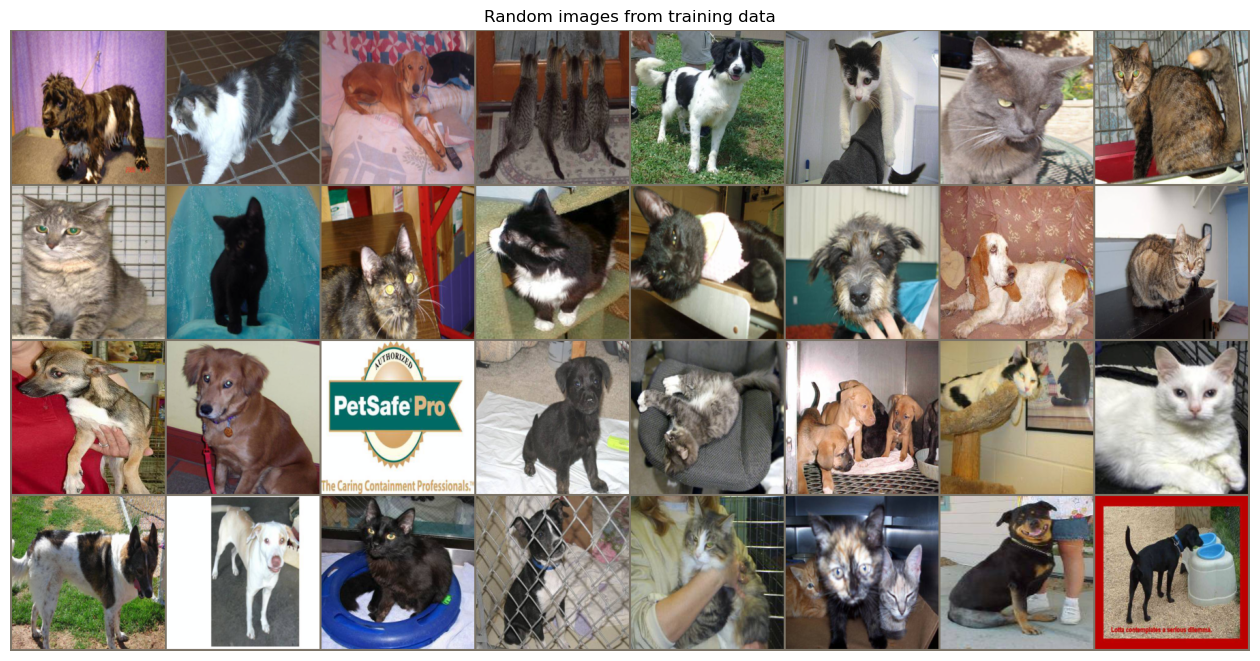

In [49]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

In [ ]:
??imshow

## Model: CNN

<img src='imgs/DogAndCats-CNN.jpg' width='100%'/>

In [51]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56 * 56 * 32, 2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = self.fc(out)
        return out

**Code description**
<hr>

**Class Definition**
```python
class SimpleCNN(nn.Module):
```
- `SimpleCNN` is a subclass of `nn.Module`, which is the base class for all neural network modules in PyTorch. This allows us to use various PyTorch functionalities and integrate with the library seamlessly.

**Initialization Method (`__init__`)**
```python
def __init__(self):
    super(SimpleCNN, self).__init__()
```
- The `__init__` method initializes the neural network. 
- `super(SimpleCNN, self).__init__()` calls the initializer of the parent class (`nn.Module`), ensuring that the module is properly set up.

**First Convolutional Block**
```python
self.conv1 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5, padding=2),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2)
)
```
- `nn.Conv2d(3, 16, kernel_size=5, padding=2)`: A 2D convolutional layer with 3 input channels (e.g., RGB images), 16 output channels (filters), a kernel size of 5x5, and padding of 2 to maintain the input size.
- `nn.BatchNorm2d(16)`: Batch normalization layer for the 16 output channels, which normalizes the outputs of the convolutional layer.
- `nn.ReLU()`: ReLU activation function, which introduces non-linearity.
- `nn.MaxPool2d(2)`: Max pooling layer with a 2x2 kernel, which downsamples the input by taking the maximum value in each 2x2 window.

**Second Convolutional Block**
```python
self.conv2 = nn.Sequential(
    nn.Conv2d(16, 32, kernel_size=5, padding=2),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2)
)
```
- `nn.Conv2d(16, 32, kernel_size=5, padding=2)`: A 2D convolutional layer with 16 input channels and 32 output channels (filters), a kernel size of 5x5, and padding of 2.
- `nn.BatchNorm2d(32)`: Batch normalization for the 32 output channels.
- `nn.ReLU()`: ReLU activation function.
- `nn.MaxPool2d(2)`: Max pooling with a 2x2 kernel.

**Fully Connected Layer**
```python
self.fc = nn.Linear(56 * 56 * 32, 2)
```
- `nn.Linear(56 * 56 * 32, 2)`: A fully connected (linear) layer that maps the flattened output of the previous layers to 2 output neurons. This implies the final output size is 2, which could be used for binary classification.

**Forward Method**
```python
def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)            # (bs, C, H,  W)
    out = out.view(out.size(0), -1)  # (bs, C * H, W)
    out = self.fc(out)
    return out
```
- `def forward(self, x)`: Defines the forward pass of the network, specifying how data flows through the network.
- `out = self.conv1(x)`: Passes the input `x` through the first convolutional block.
- `out = self.conv2(out)`: Passes the output from the first block through the second convolutional block.
- `out = out.view(out.size(0), -1)`: Flattens the output from the second block to a 1D tensor. `out.size(0)` is the batch size, and `-1` infers the remaining dimensions to make the tensor flat.
- `out = self.fc(out)`: Passes the flattened tensor through the fully connected layer.
- `return out`: Returns the final output of the network.

**Overall Summary**
- The `SimpleCNN` class constructs a simple CNN with two convolutional layers followed by batch normalization, ReLU activation, and max pooling. Finally, a fully connected layer maps the processed features to the output. The forward method defines how input data flows through these layers during the forward pass.


<hr>

__Now, it's time to create the model and to put it on the GPU.__

In [55]:
model = SimpleCNN()

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [57]:
torch.cuda.is_available()

True

In [59]:
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=2, bias=True)
)

## __Loss function and optimizer__

- During each training iteration (epoch), the model makes predictions on the input data.
- The `criterion` calculates the loss between the predicted outputs and the true labels.
- The `optimizer` adjusts the model parameters to minimize this loss using the gradients calculated from the loss.

By defining the loss function and the optimizer in this way, you set up the essential components needed to train a neural network in PyTorch.

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

## Train

In [65]:
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        # Moves the input data and targets to the specified device (CPU or GPU).
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # forwad pass
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))

Epoch [ 1/10], Step [ 50/ 62], Loss: 1.6508
Epoch [ 2/10], Step [ 50/ 62], Loss: 0.5944
Epoch [ 3/10], Step [ 50/ 62], Loss: 0.6098
Epoch [ 4/10], Step [ 50/ 62], Loss: 0.5157
Epoch [ 5/10], Step [ 50/ 62], Loss: 0.7005
Epoch [ 6/10], Step [ 50/ 62], Loss: 0.5154
Epoch [ 7/10], Step [ 50/ 62], Loss: 0.3902
Epoch [ 8/10], Step [ 50/ 62], Loss: 0.4907
Epoch [ 9/10], Step [ 50/ 62], Loss: 0.2857
Epoch [10/10], Step [ 50/ 62], Loss: 0.3450


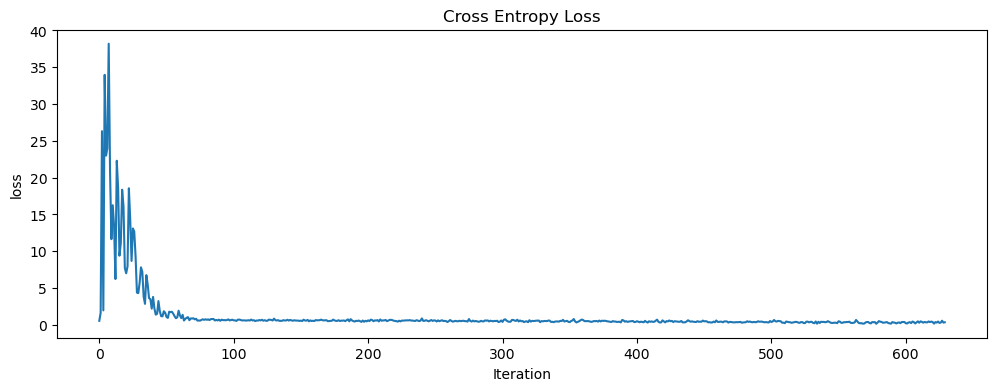

In [79]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

#### Accuracy on validation data

In [82]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
     
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

Detailed Explanation

1. **Function Definition**: 
    ```python
    def evaluate_model(model, dataloader, device):
    ```
    - The function `evaluate_model` takes three arguments: `model`, `dataloader`, and `device`.
      - `model`: The neural network model to be evaluated.
      - `dataloader`: An iterable that provides batches of input data and corresponding targets.
      - `device`: The device (CPU or GPU) on which the evaluation is to be performed.

2. **Set the Model to Evaluation Mode**:
    ```python
    model.eval()  # for batch normalization layers
    ```
    - `model.eval()`: Sets the model to evaluation mode. This is necessary because certain layers like dropout and batch normalization behave differently during training and evaluation. This line ensures that the model behaves appropriately during evaluation.

3. **Initialize Correct Predictions Counter**:
    ```python
    corrects = 0
    ```
    - `corrects`: This variable will keep track of the number of correct predictions made by the model.

4. **Disable Gradient Calculation**:
    ```python
    with torch.no_grad():
    ```
    - `torch.no_grad()`: Context manager to disable gradient calculation. This reduces memory usage and speeds up computations since gradients are not needed during evaluation.

5. **Iterate Over Batches in the Dataloader**:
    ```python
    for inputs, targets in dataloader:
    ```
    - Loop over each batch of `inputs` and `targets` provided by the `dataloader`.

6. **Move Data to the Specified Device**:
    ```python
    inputs, targets = inputs.to(device), targets.to(device)
    ```
    - Moves the `inputs` and `targets` tensors to the specified device (CPU or GPU).

7. **Forward Pass through the Model**:
    ```python
    outputs = model(inputs)
    ```
    - Perform a forward pass through the model to obtain the raw output predictions.

8. **Obtain Predicted Classes**:
    ```python
    _, preds = torch.max(outputs, 1)
    ```
    - `torch.max(outputs, 1)`: Computes the maximum value along dimension 1 (the class dimension) of `outputs`. The function returns a tuple where the first element is the maximum value and the second element is the index of the maximum value. `_` is used to ignore the first element, and `preds` stores the indices of the maximum values, which correspond to the predicted class labels.

9. **Count Correct Predictions**:
    ```python
    corrects += (preds == targets.data).sum()
    ```
    - Compares the predicted class labels (`preds`) with the true class labels (`targets.data`) and sums the number of correct predictions. This sum is added to the `corrects` counter.

10. **Calculate and Print Accuracy**:
    ```python
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))
    ```
    - Computes the accuracy as the percentage of correct predictions out of the total number of samples in the dataset. 
    - `100. * corrects / len(dataloader.dataset)`: The number of correct predictions is divided by the total number of samples and then multiplied by 100 to get the accuracy percentage.
    - `'{:.2f}'.format(...)`: Formats the accuracy to two decimal places.
    - `print(...)`: Prints the formatted accuracy to the console.

In [84]:
evaluate_model(model, valid_dl, device)

accuracy: 61.00


In [85]:
evaluate_model(model, train_dl, device)

accuracy: 91.05


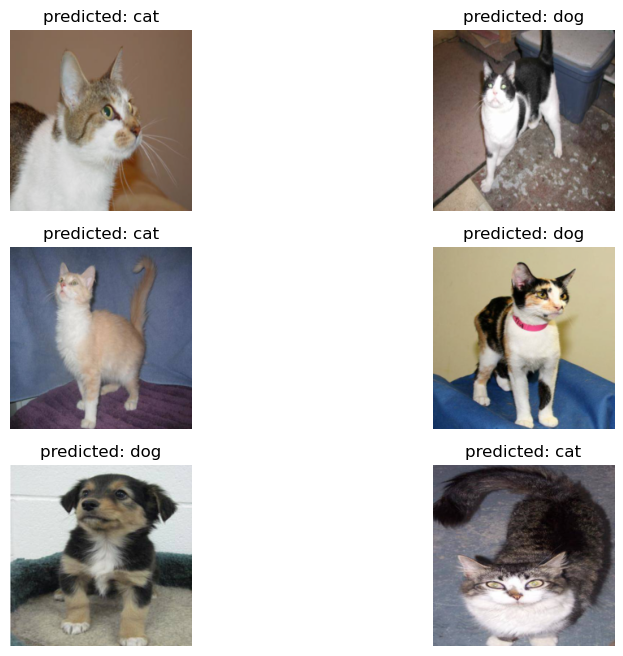

In [86]:
visualize_model(model, train_dl, device)

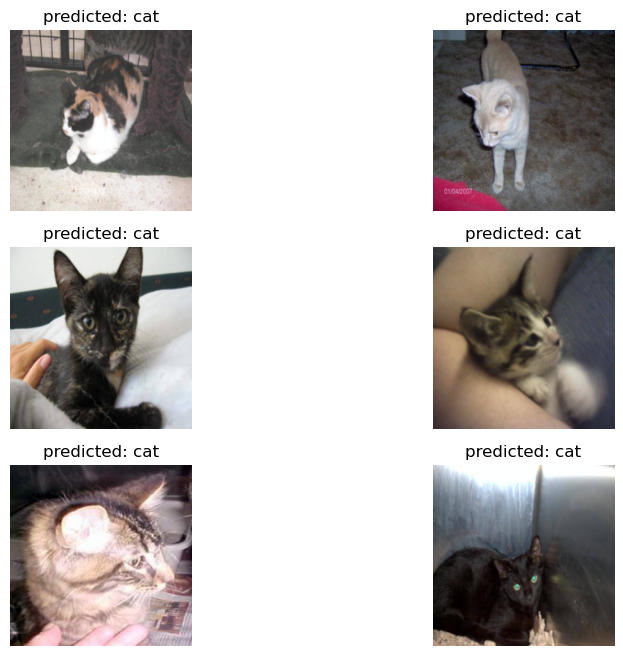

In [87]:
visualize_model(model, valid_dl, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


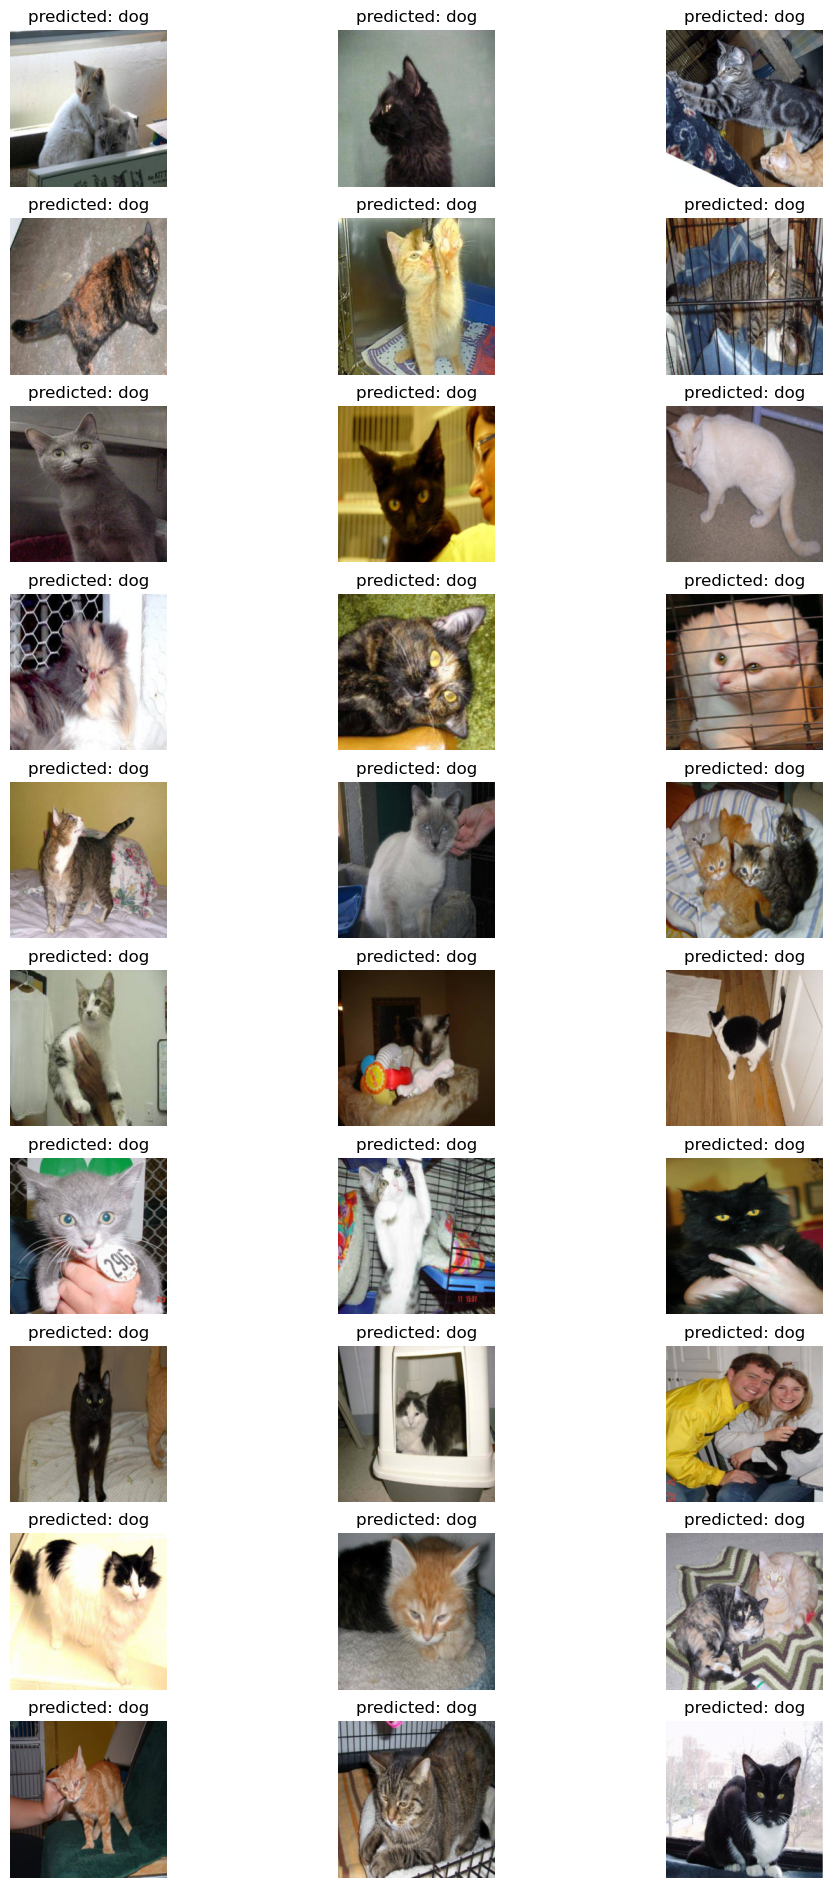

44 images out of 500 were misclassified.


In [88]:
plot_errors(model, valid_dl, device)

#### Confusion matrix

**Confusion Matrix Explanation**

A **confusion matrix** is a table used to evaluate the performance of a classification model. It summarizes the results of the classification by comparing the actual labels with the predicted labels. Each row of the matrix represents the instances in an actual class, while each column represents the instances in a predicted class.

Here is an example of a confusion matrix for a binary classification problem:

|                | Predicted Positive | Predicted Negative |
|----------------|--------------------|--------------------|
| **Actual Positive** | True Positive (TP)      | False Negative (FN)     |
| **Actual Negative** | False Positive (FP)     | True Negative (TN)      |

- **True Positive (TP)**: The model correctly predicted the positive class.
- **False Positive (FP)**: The model incorrectly predicted the positive class (Type I error).
- **False Negative (FN)**: The model incorrectly predicted the negative class (Type II error).
- **True Negative (TN)**: The model correctly predicted the negative class.

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.60it/s]


[[0.54 0.46]
 [0.32 0.68]]


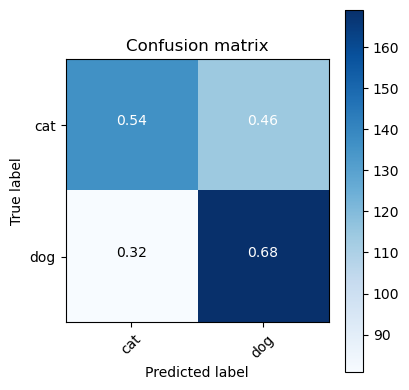

In [90]:
y_pred, y_true = predict_class(model, valid_dl, device)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))

## Overfit

Overfitting occurs when a model learns the training data too well, capturing noise and details that do not generalize to new, unseen data.

<h6>What we can do about it?</h6>

- **Regularization**: Adds a penalty to the loss function to constrain the model's complexity, discouraging overfitting by preventing it from fitting noise in the data.For further reading, please refer to this [repository](https://github.com/amirjahantab/regularization/).
- **Dropout**: Randomly deactivates a fraction of neurons during training to prevent coadaptation and improve generalization.
- **Data Augmentation**: Expands the training dataset by applying random transformations, such as rotation or flipping, to reduce overfitting and improve model robustness.
- **Transfer Learning**: Utilizes pre-trained models on similar tasks to improve performance and generalization on a new, often smaller, dataset.

## Data Augmentation

<img src='imgs/Augmentation.jpg' width='90%'/>

<h6>Possible Transformations:</h6>
- Scaling
- Rotation
- Translation
- Flip horizontaly
- Random Crop
- Color jitter
- many more!

<img src='imgs/Augmentation-Examples.jpg' width='75%'/>

In [101]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(), 
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}train', train_transforms)
valid_ds = datasets.ImageFolder(f'{DATA_DIR}valid', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 2000
Valid size: 500 (0.20)


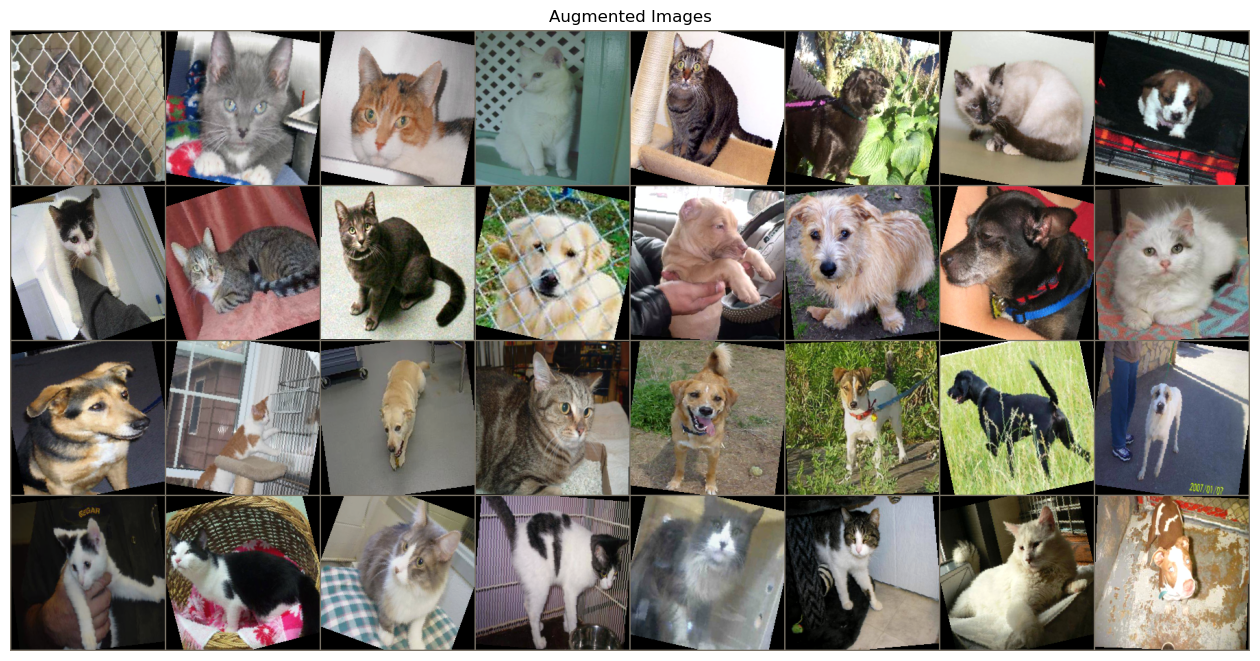

In [103]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images');

#### Look at the sizes of the images

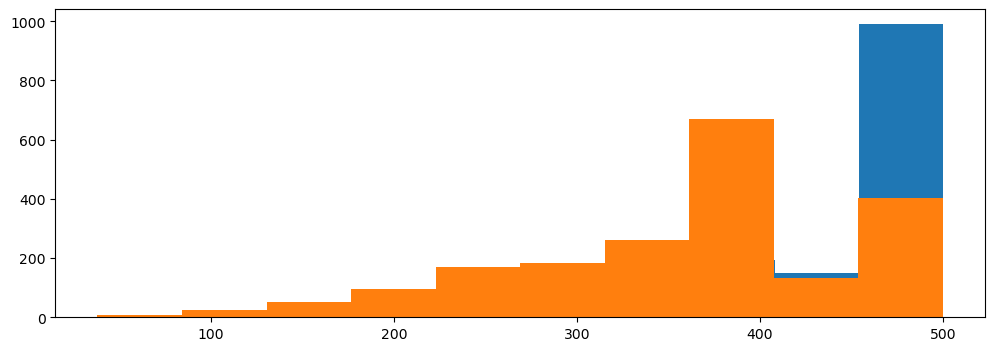

In [105]:
fnames = glob.glob(f'{trn_dir}/*/*.jpg')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [109]:
# create model
model = SimpleCNN()
model = model.to(device)
    
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# train
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, num_epochs=5)

Epoch 1/5
----------
  train Loss: 7.04121 Acc: 0.54950
  valid Loss: 1.60434 Acc: 0.50800

Epoch 2/5
----------
  train Loss: 0.84534 Acc: 0.55200
  valid Loss: 0.66283 Acc: 0.61200

Epoch 3/5
----------
  train Loss: 0.64825 Acc: 0.61950
  valid Loss: 0.63675 Acc: 0.64200

Epoch 4/5
----------
  train Loss: 0.62077 Acc: 0.63700
  valid Loss: 0.63223 Acc: 0.63400

Epoch 5/5
----------
  train Loss: 0.61884 Acc: 0.65050
  valid Loss: 0.61857 Acc: 0.66800

Training complete in 3m 24s
Best val Acc: 0.6680


## Transfer Learning

- Use a CNN already trained on different data (e.g., [ImageNet](http://www.image-net.org/))
- Just Train the classifier weights (Last Layer)

<img src='imgs/transfer-learning.jpg' width='80%'/>

In [113]:
# load pre-trained ResNet18
model = load_pretrained_resnet50(model_path=None, num_classes=2)
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Amir/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:36<00:00, 2.84MB/s]


In [127]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=2)

Epoch 1/2
----------
  train Loss: 0.05140 Acc: 0.98150
  valid Loss: 0.10273 Acc: 0.96400

Epoch 2/2
----------
  train Loss: 0.02467 Acc: 0.99150
  valid Loss: 0.05851 Acc: 0.97800

Training complete in 2m 15s
Best val Acc: 0.9780


In [129]:
evaluate_model(model, valid_dl, device)

accuracy: 97.80


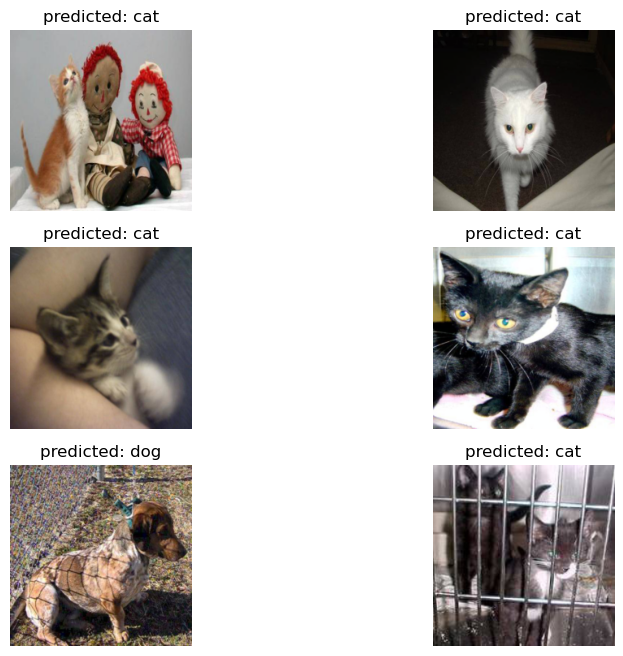

In [119]:
visualize_model(model, valid_dl, device, num_images=6)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.81it/s]


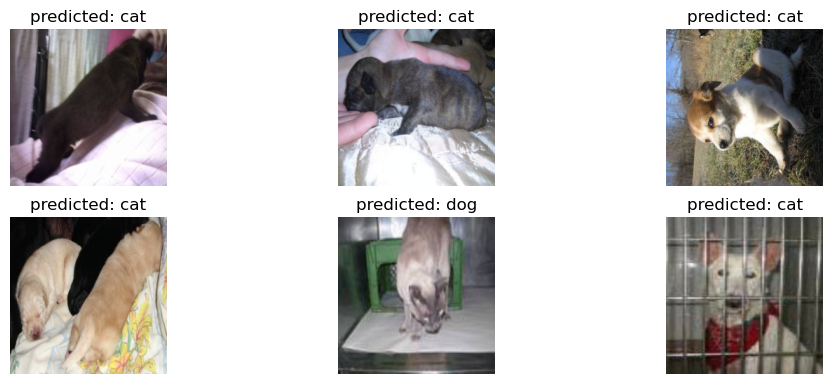

6 images out of 500 were misclassified.


In [120]:
plot_errors(model, valid_dl, device)